In [1]:
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from tqdm import tqdm

In [2]:
# set params
u_list = [175, 200, 225, 250]
q_list = [215, 304, 429]
d_list = [18, 24, 30]

# set dir
BINARY_DIR = '../data/binary/'
BOUNDARY_DIR = '../data/boundary/'

In [3]:

def detect_boundary(img, hei, wid, t=5):
    data = np.zeros((hei, 5))  # [index, start, end, flag, flag]

    # detection boundary
    for j in range(hei):
        data[j][0] = j  # index

        # detection from left side
        for i in range(wid - t):
            if np.all(img[j][i:i + t] == 255):
                data[j][1] = i
                data[j][3] = 1

                break

        # detection from right side
        if j > 700:
            for i in reversed(range(t, wid)):
                if np.all(img[j][i - t:i] == 255):
                    data[j][2] = i

                    if i > 1200:
                        data[j][4] = 0
                    else:
                        data[j][4] = 1

                    break

    return data

In [4]:
def parabola_fit(data):
    def _parabola(_x, *params):
        _y = np.zeros_like(_x)

        for _i, _param in enumerate(params):
            _y += np.array(_param * _x ** _i)

        return _y

    a = np.zeros(1)
    b = np.zeros(1)

    for i in range(data.shape[0]):
        # left boundary
        if data[i, 3] == 1:
            a = np.append(a, data[i, 0])
            b = np.append(b, data[i, 1])

        # right boundary
        if data[i, 4] == 1:
            a = np.append(a, data[i, 0])
            b = np.append(b, data[i, 2])

    p, cov = curve_fit(_parabola, b[1:], a[1:], p0=[1, 1, 1])

    return p, cov, a, b

In [5]:
def m_fit(v, a, b):
    def _model_func_m_xy(_x, _m):
        return _x / np.tan(np.pi - v * _x / _m)

    return curve_fit(_model_func_m_xy, b, a, p0=[100])

In [16]:
def check_parabola_fitting(popt, a, b):
    fig, ax = plt.subplots(figsize=(12, 10))
    plt.xlabel('$\it{x}$ [px]', fontsize=28)
    plt.ylabel('$\it{y}$ [px]', fontsize=28)
    plt.title(f"[u, q, d] = [{u}, {q}, {d}]")
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlim(0 + popt[1] / popt[2] / 2, 1280 + popt[1] / popt[2] / 2)
    plt.ylim((0 + (popt[1]**2 - 4 * popt[2] * popt[0]) / popt[2] / 4), -(1024 + (popt[1]**2 - 4 * popt[2] * popt[0]) / popt[2] / 4))
    plt.grid()

    x = np.linspace(0, 1280 - 1, 1280)
    y = popt[0] + popt[1] * x + popt[2] * x ** 2

    x += popt[1] / popt[2] / 2
    y += (popt[1]**2 - 4 * popt[2] * popt[0]) / popt[2] / 4
    a += popt[1] / popt[2] / 2
    b += (popt[1]**2 - 4 * popt[2] * popt[0]) / popt[2] / 4

    plt.plot(x, -y, color='r', linewidth=3)
    plt.scatter(b[1:], -a[1:], c='k')

    plt.show()

  0%|          | 0/4 [00:21<?, ?it/s]


KeyboardInterrupt: 

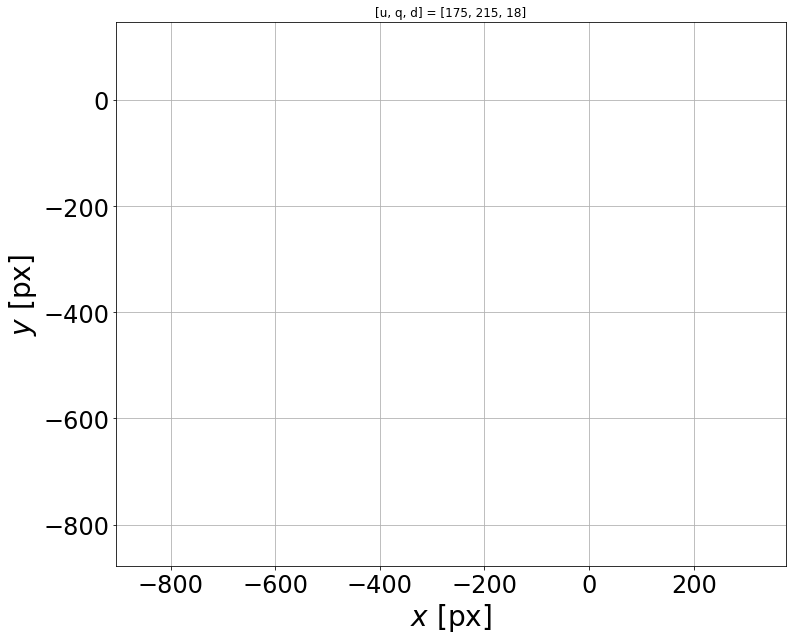

In [18]:
for u in tqdm(u_list):
    for q in q_list:
        for d in d_list:
            # read mask img
            bin_img = cv2.imread(BINARY_DIR + f'b_u_{u}_q_{q}_d_{d}_ppm_0.bmp', 0)

            # detect boundary
            boundary = detect_boundary(img=bin_img, hei=1024, wid=1280)

            # parabola fitting
            popt_p, pcov_p, A, B = parabola_fit(boundary)

            # check parabola fitting
            check_parabola_fitting(popt_p, A, B)

            print(0)
